# Explore the data

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../../hand_made_stuff')
from handmadestuff import fit_predict_report
import statsmodels.formula.api as sm

# Importing data
loan_df = pd.read_csv('data/loan.csv')

# Dropping rows containing NaN values
loan_df = loan_df.dropna().iloc[:, 1:]

# Display how the data looks
loan_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


# Preprocess the data

In [2]:
# Splitting the dataset into the source and the target values
X = loan_df.iloc[:, :11].values
y = loan_df.iloc[:, -1].values

In [3]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Encoding the source values
labelencoder_X = LabelEncoder()
categorical_sources = [0, 1, 2, 3, 4, 10]
for i in categorical_sources:
    X[:, i] = labelencoder_X.fit_transform(X[:, i])
    
# Encoding the target values (N, Y => 0, 1)
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

In [4]:
# Splitting the source values into the categorical and the continuous variables
X_1 = X[:, categorical_sources]
X_2 = X[:, [item for item in list(range(len(X[0]))) if item not in categorical_sources]]

In [5]:
# Hot encoding the categorical values

# X_1 is a numpy array, which shape is (480, 6).
# Second and fifth columns are the only that, contain values higher than 1
onehotencoder = OneHotEncoder()
X_1_encoded = onehotencoder.fit_transform(X_1[:, [2, 5]]).toarray()[:, 1:6]

# Columns [0, 1, 3, 4] contain only 0 and 1 values, thus not needed to be hot encoded
X_1_not_encoded = X_1[:, [0, 1, 3, 4]]

# Concatenating X_1_encoded with X_1_not_encoded to obtain X_1 with hot encoded values
X_1 = np.concatenate((X_1_not_encoded, X_1_encoded), axis = 1).astype('int')
# Concatenating X_1 and X_2 to obtain X
X = np.concatenate((X_1, X_2.astype(int)), axis = 1)

# Evaluating the variables' significance

In [6]:
# Defining the function for model optimization (with p-values only)
def backward_elimination_p(x, y, sl):
    numVars = len(x[0])
    for i in range(numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            x = np.delete(x, list(regressor_OLS.pvalues).index(maxVar), 1)
    print(regressor_OLS.summary())
    return x

In [7]:
# Defining the function for model optimization (with p-values and Adjusted R Squared)
import statsmodels.formula.api as sm
def backward_elimination_p_r(x, y, SL):
    numVars = len(x[0])
    temp = np.zeros(x.shape).astype(int)
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if maxVar > SL:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    temp[:,j] = x[:, j]
                    x = np.delete(x, j, 1)
                    tmp_regressor = sm.OLS(y, x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):
                        x_rollback = np.hstack((x, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        print (regressor_OLS.summary())
                        return x_rollback
                    else:
                        continue
    regressor_OLS.summary()
    return x

In [8]:
# Displaying the significance of all variables
X = np.append(np.ones((X.shape[0], 1)), X, axis = 1)
regressor_OLS = sm.OLS(y, X).fit()
print(regressor_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     15.81
Date:                Wed, 14 Nov 2018   Prob (F-statistic):           1.40e-31
Time:                        23:38:33   Log-Likelihood:                -216.80
No. Observations:                 480   AIC:                             463.6
Df Residuals:                     465   BIC:                             526.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1120      0.121      0.928      0.3

In [9]:
# Elimintaing non significant sources (evaluating only by p-values). 
# Reducing the amount of the source values
SL = 0.05
X_opt = X
X_modeled_p = backward_elimination_p(X_opt, y, SL)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     584.7
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          2.47e-159
Time:                        23:38:37   Log-Likelihood:                -222.35
No. Observations:                 480   AIC:                             450.7
Df Residuals:                     477   BIC:                             463.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0928      0.033      2.784      0.0

In [10]:
# Elimintaing non significant sources (evaluating by p-values and Adjusted R Squared). 
# Reducing the amount of the source values
X_modeled_p_r = backward_elimination_p_r(X_opt, y, SL)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     222.3
Date:                Wed, 14 Nov 2018   Prob (F-statistic):          9.19e-155
Time:                        23:38:39   Log-Likelihood:                -217.76
No. Observations:                 480   AIC:                             451.5
Df Residuals:                     472   BIC:                             484.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0750      0.045      1.667      0.0

In [11]:
# Adj. R-squared (only p-values method) == 0.785
# Adj. R-squared (p-values and Adjusted R Squared method) == 0.787
# 
# Not a significatn difference, so I'll choose the model with fewer variables, 
# therefore I choose X_modeled_p for the source values

In [12]:
# Splitting the dataset into the train and the test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_modeled_p, y, test_size = 0.2,
                                                    random_state = 0)

In [13]:
# # Scaling the data
# from sklearn.preprocessing import StandardScaler
# sc_X = StandardScaler()
# X_train = sc_X.fit_transform(X_train)
# X_test = sc_X.transform(X_test)

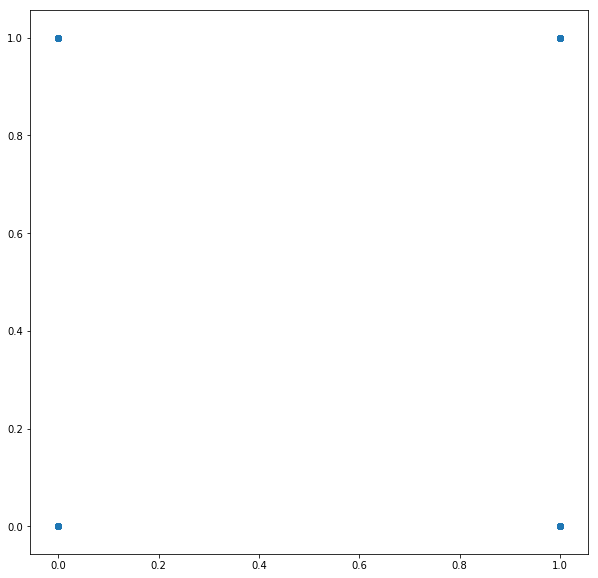

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

ax.scatter(X_modeled_p[:, 0], X_modeled_p[:, 1])

# Training the models and predicting test set results

In [22]:
fit_predict_report(loan_df, 'knn', X_train, y_train, X_test, y_test)

Classificator used:
 knn


Confusion matrix: 

 [[19 16]
 [11 50]] 


Classification report:

              precision    recall  f1-score   support

          0       0.63      0.54      0.58        35
          1       0.76      0.82      0.79        61

avg / total       0.71      0.72      0.71        96



In [16]:
fit_predict_report(loan_df, 'svc', X_train, y_train, X_test, y_test)

Classificator used:
 svc


Confusion matrix: 

 [[13 22]
 [ 0 61]] 


Classification report:

              precision    recall  f1-score   support

          0       1.00      0.37      0.54        35
          1       0.73      1.00      0.85        61

avg / total       0.83      0.77      0.74        96



In [17]:
fit_predict_report(loan_df, 'lr', X_train, y_train, X_test, y_test)

Classificator used:
 lr


Confusion matrix: 

 [[13 22]
 [ 0 61]] 


Classification report:

              precision    recall  f1-score   support

          0       1.00      0.37      0.54        35
          1       0.73      1.00      0.85        61

avg / total       0.83      0.77      0.74        96

